# Introduction to autonomous vehicles - Task 1 Perception

## Task Description

Select a Dataset of road traffic containing annotated objects. 
Please select a method and use this dataset to train a model to detect and classify **Pedestrians, Cyclists and Vehicles** on a Video Clip. 
The video clip could be from the dataset or from other sources.

**Available Datasets:**

- [KITTI Dataset](https://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark)
- [COCO Dataset](https://cocodataset.org/)
- [Waymo Dataset](https://console.cloud.google.com/storage/browser/waymo_open_dataset_v_1_2_0_individual_files)
  - **Note:** You might have to first register [here](https://waymo.com/open/) to get access to the dataset.

**Rules:**

- Use whatever framework you prefer (Pytroch, Tensorflow, ultralytics, etc.)
- Recommended to use any version of YOLO
- Use the code from the GitHub repository of the previous mentioned or other published methods (e.g. https://github.com/ultralytics/yolov3)
- Use pretrained weights
  - **Note:** You can use the pretrained weights, but you have to train and adapt them to your dataset.

**Requirements:**

You should set up the environment accordingly. For now you can use the below code to install the required packages.

In [1]:
!pip install torch torchvision torchaudio
!pip install ipykernel
!pip install jupyterlab
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 2.4/2.4 MB 23.5 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from ultralytics import settings
from ultralytics import YOLO
import os
from pathlib import Path

In [16]:
# Configure the ultralytics settings, since the default settings might not work or are leftover from previous runs

# Get current working directory from system
working_dir = os.getcwd()
settings['datasets_dir'] = Path(working_dir + '/../datasets').resolve().__str__()
settings['weights_dir'] = Path(working_dir + '/weights').resolve().__str__()
settings['runs_dir'] = Path(working_dir + '/runs').resolve().__str__()

settings

{'settings_version': '0.0.6',
 'datasets_dir': 'C:\\Users\\Daniel\\OneDrive - Elektro-, Veranstaltungs- und Informationstechnik Austria\\Dokumente\\JKU\\Intro to autonom vehicles\\Assigments\\1\\intro_to_autonomous_vehicles_2025\\datasets',
 'weights_dir': 'C:\\Users\\Daniel\\OneDrive - Elektro-, Veranstaltungs- und Informationstechnik Austria\\Dokumente\\JKU\\Intro to autonom vehicles\\Assigments\\1\\intro_to_autonomous_vehicles_2025\\task1\\weights',
 'runs_dir': 'C:\\Users\\Daniel\\OneDrive - Elektro-, Veranstaltungs- und Informationstechnik Austria\\Dokumente\\JKU\\Intro to autonom vehicles\\Assigments\\1\\intro_to_autonomous_vehicles_2025\\task1\\runs',
 'uuid': 'ce5394ae069f9ca211b33c2ac8565c0ab27fb2e17f1adc5e86e8c190730c3803',
 'sync': True,
 'api_key': '',
 'openai_api_key': '',
 'clearml': True,
 'comet': True,
 'dvc': True,
 'hub': True,
 'mlflow': True,
 'neptune': True,
 'raytune': True,
 'tensorboard': True,
 'wandb': False,
 'vscode_msg': True}

## Dataset

For our first project we chose the provided **COCO Dataset**

It is an open dataset for region segmentation, that is hosted as a challenge. As such, **the test set annotations are not available**.

The COCO dataset has 80 object categories, including common objects like cars, bicycles, and animals, as well as more specific categories such as umbrellas, handbags, and sports equipment. For our task we will not need all of these, but luckily with the implementation of ultralytics we can select a subset of these to train on.

Concretely we will group them as:
### Pedestrians
* Person
* Dog
* Cow
* Horse
* Cat

### Vehicle
* Motorcycle
* Bus
* Car
* Truck
* Train

### Cyclist
* Bicycle



TODO: visualize some of the stats of the dataset, as well as some example images with annotations

In [17]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import os

# Path to COCO annotations file (change to your dataset path)
ann_file = settings['datasets_dir'] + "\\coco\\annotations\\instances_val2017.json"
img_dir = settings['datasets_dir'] + "\\coco\\val2017"

# Load COCO dataset
coco = COCO(ann_file)

# Get all category names
categories = coco.loadCats(coco.getCatIds())
category_names = [cat['name'] for cat in categories]
print(f"COCO Categories: {category_names}")

loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
COCO Categories: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


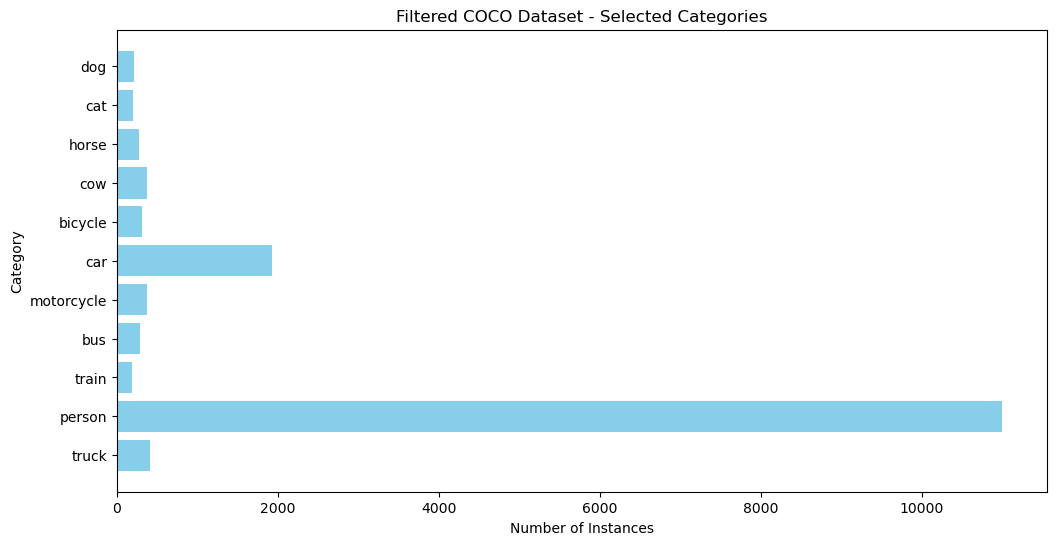

In [24]:
from collections import Counter
import matplotlib.pyplot as plt

# Define the categories we want to include
desired_classes = ["person", "bicycle", "car", "motorcycle", "bus", "train", "truck", "cat", "dog", "horse", "cow"]

# Get the category IDs for the desired classes
desired_cat_ids = [cat['id'] for cat in coco.cats.values() if cat['name'] in desired_classes]

# Count instances for only these categories
category_counts = Counter()

for ann in coco.anns.values():
    if ann["category_id"] in desired_cat_ids:
        category_counts[ann["category_id"]] += 1

# Convert category IDs to names
category_names = [coco.cats[cat_id]["name"] for cat_id in category_counts.keys()]
category_values = list(category_counts.values())

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.barh(category_names, category_values, color="skyblue")
plt.xlabel("Number of Instances")
plt.ylabel("Category")
plt.title("Filtered COCO Dataset - Selected Categories")
plt.gca().invert_yaxis()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Daniel\\OneDrive - Elektro-, Veranstaltungs- und Informationstechnik Austria\\Dokumente\\JKU\\Intro to autonom vehicles\\Assigments\\1\\intro_to_autonomous_vehicles_2025\\datasets\\coco\\val2017\\000000549390.jpg'

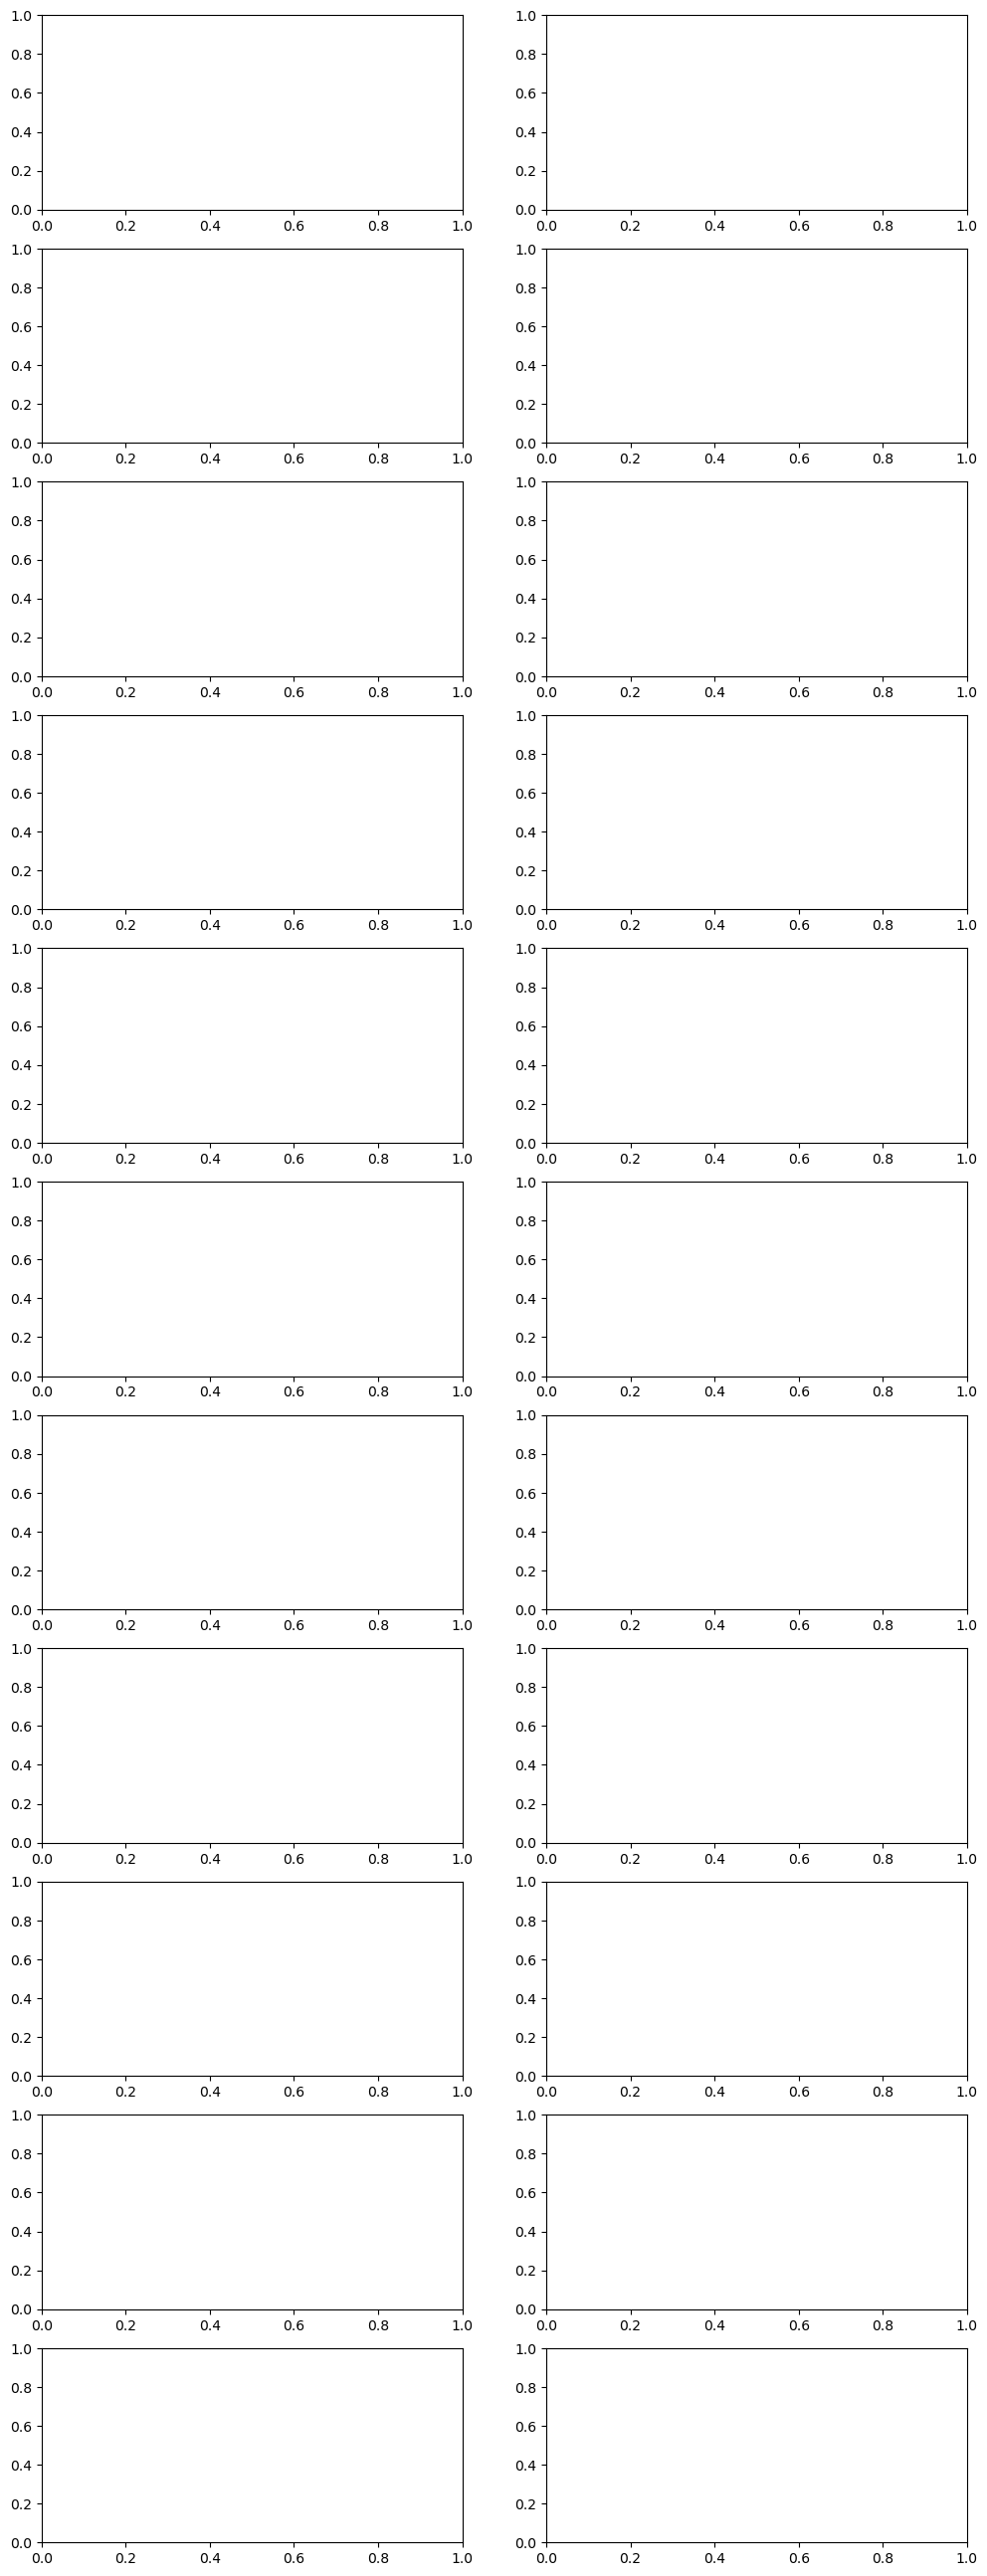

In [28]:
# Bild-IDs für jede gewünschte Klasse abrufen
selected_images = []
for cat_id in desired_cat_ids:
    img_ids = coco.getImgIds(catIds=[cat_id])  # Alle Bild-IDs für die Klasse
    random.shuffle(img_ids)  # Zufällige Reihenfolge
    selected_images.extend(img_ids[:2])  # Zwei Bilder pro Klasse hinzufügen

# Entferne doppelte Bild-IDs, falls mehrere Klassen in einem Bild sind
selected_images = list(set(selected_images))

# Bilder anzeigen
fig, axes = plt.subplots(len(selected_images) // 2, 2, figsize=(12, len(selected_images) * 1.5))

for i, img_id in enumerate(selected_images):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])
    
    # Bild laden
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot
    ax = axes[i // 2, i % 2]
    ax.imshow(img)
    ax.set_title(f"Bild {img_info['file_name']}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Training

For a first attempt, we can use ultralytics' implementation of a training without any augmentations, which we can add later to check and compare results.

TODO: actually run and train the model with parameters setting like in: https://docs.ultralytics.com/modes/train/

In [26]:
# Load a model
model = YOLO("yolo11n.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="coco.yaml", epochs=5, imgsz=640)

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.6.0 CPU (Apple M1 Max)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=coco.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format

Unzipping /Users/lukaskurz/University/datasets/coco2017labels-segments.zip to /Users/lukaskurz/University/datasets/coco...: 100%|██████████| 122232/122232 [00:09<00:00, 12247.44file/s]

KeyboardInterrupt: 

## Evaluation

TODO evaluate the model, consult this website.

https://docs.ultralytics.com/modes/val/

In [ ]:
# Load a model
model = YOLO("yolo11n.pt")  # load an official model
model = YOLO("path/to/best.pt")  # load a custom model

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map  # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps  # a list contains map50-95 of each category

## Video Prediction

For our task, we should create an annotate result from some video. With this, we should use a video of road traffic, which we then annotate with our trained model, image by image, comparing different trained models.

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")  # pretrained YOLO11n model

# Run batched inference on a list of images
results = model(["image1.jpg", "image2.jpg"])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk